In [1]:
# Sai Krishna Sri Gundam

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, lower, count, sum, when
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
! hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [4]:
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/08 01:58:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# TODO: modify to treat the first row as a header
# TODO: modify to infer the schema
banks_df = spark.read.csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv", header=True, inferSchema=True)
banks_df.limit(2).toPandas()

,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,First National Bank,110004,5493003EW6T31TGECO83,5493003EW6T31TGECO83,5493003EW6T31TGECO83
1,"First Mid Bank & Trust, National Association",110045,549300XOTES5TCS8T794,549300XOTES5TCS8T794,549300XOTES5TCS8T794


In [6]:
rdd = banks_df.rdd
rows = rdd.take(3)
rows

[Row(respondent_name='First National Bank', arid_2017='110004', lei_2018='5493003EW6T31TGECO83', lei_2019='5493003EW6T31TGECO83', lei_2020='5493003EW6T31TGECO83'),
 Row(respondent_name='First Mid Bank & Trust, National Association', arid_2017='110045', lei_2018='549300XOTES5TCS8T794', lei_2019='549300XOTES5TCS8T794', lei_2020='549300XOTES5TCS8T794'),
 Row(respondent_name='First Hope Bank, A National Banking Association', arid_2017='110118', lei_2018='5493003XLOX5FDT9R120', lei_2019='5493003XLOX5FDT9R120', lei_2020='5493003XLOX5FDT9R120')]

In [7]:
#q1
rdd = banks_df.rdd
first_rdd = rdd.filter(lambda row: "first" in row["respondent_name"].lower())
count_firsts_rdd = first_rdd.count()
count_firsts_rdd

525

In [8]:
#q2
first_df = banks_df.filter(lower(col("respondent_name")).like("%first%"))
count_firsts_df = first_df.count()
count_firsts_df

525

In [9]:
banks_df.write.saveAsTable("banks", mode="overwrite")

23/11/08 01:59:19 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/08 01:59:19 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/08 01:59:23 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/08 01:59:23 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.24.0.2
23/11/08 01:59:24 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/11/08 01:59:29 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/11/08 01:59:29 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/11/08 01:59:29 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/08 01:59:29 W

In [10]:
#q3
first_sql = spark.sql("SELECT COUNT(*) AS count FROM banks WHERE LOWER(respondent_name) LIKE '%first%'")
count_first_sql = first_sql.collect()[0]["count"]
count_first_sql

525

In [11]:
loans_df = spark.read.csv("hdfs://nn:9000/hdma-wi-2021.csv", header=True, inferSchema=True)

In [12]:
loans_df.write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")

23/11/08 01:59:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [13]:
spark.table("loans").limit(2).toPandas()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2021,549300FQ2SN6TRRGB032,99999,WI,55055,55055100602,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3351,2.98,69600,112,1201,1689,38
1,2021,254900HA4DQWAE0W3342,31540,WI,55025,55025012700,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,4053,3.38,99000,109,1346,1638,27


In [14]:
df = spark.read.csv(f"hdfs://nn:9000/ethnicity.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("ethnicity")

In [15]:
df = spark.read.csv(f"hdfs://nn:9000/race.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("race")

In [16]:
df = spark.read.csv(f"hdfs://nn:9000/sex.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("sex")

In [17]:
df = spark.read.csv(f"hdfs://nn:9000/states.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("states")

In [18]:
df = spark.read.csv(f"hdfs://nn:9000/counties.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("counties")

In [19]:
df = spark.read.csv(f"hdfs://nn:9000/tracts.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("tracts")

In [20]:
df = spark.read.csv(f"hdfs://nn:9000/action_taken.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("action_taken")

In [21]:
df = spark.read.csv(f"hdfs://nn:9000/denial_reason.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("denial_reason")

In [22]:
df = spark.read.csv(f"hdfs://nn:9000/loan_type.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("loan_type")

In [23]:
df = spark.read.csv(f"hdfs://nn:9000/preapproval.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("preapproval")

In [24]:
df = spark.read.csv(f"hdfs://nn:9000/property_type.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("property_type")

In [25]:
df = spark.read.csv(f"hdfs://nn:9000/loan_purpose.csv", header=True, inferSchema=True)
df.createOrReplaceTempView("loan_purpose")

In [26]:
#q4
df = spark.sql("SHOW TABLES")
dict_tables = {row["tableName"]: row["isTemporary"] for row in df.collect()}
dict_tables

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [27]:
#q5
join_sql = spark.sql("""
SELECT COUNT(*) AS appli_count
FROM loans
INNER JOIN banks
ON loans.lei = banks.lei_2020
WHERE banks.lei_2020 IN (select lei_2020 from banks where banks.respondent_name = "University of Wisconsin Credit Union")
""")
loan_app_count = join_sql.collect()[0]["appli_count"]
loan_app_count

19739

In [28]:
#q6
spark.sql("""
SELECT COUNT(*) AS appli_count
FROM loans
INNER JOIN banks
ON loans.lei = banks.lei_2020
WHERE banks.lei_2020 IN (select lei_2020 from banks where banks.respondent_name = "University of Wisconsin Credit Union")
""").explain("formatted")

#The "banks" table is sent to every executor via a BroadcastExchange operation at 6, 13, and 15.
#The plan involves HashAggregate operations at indexes 18 and 20, at HashAggregate(18) the partial count is calculated and
# at HashAggregate(20) a regular count is calculated.

== Physical Plan ==
AdaptiveSparkPlan (21)
+- HashAggregate (20)
   +- Exchange (19)
      +- HashAggregate (18)
         +- Project (17)
            +- BroadcastHashJoin Inner BuildRight (16)
               :- BroadcastHashJoin LeftSemi BuildRight (7)
               :  :- Filter (2)
               :  :  +- Scan parquet spark_catalog.default.loans (1)
               :  +- BroadcastExchange (6)
               :     +- Project (5)
               :        +- Filter (4)
               :           +- Scan parquet spark_catalog.default.banks (3)
               +- BroadcastExchange (15)
                  +- BroadcastHashJoin LeftSemi BuildRight (14)
                     :- Filter (9)
                     :  +- Scan parquet spark_catalog.default.banks (8)
                     +- BroadcastExchange (13)
                        +- Project (12)
                           +- Filter (11)
                              +- Scan parquet spark_catalog.default.banks (10)


(1) Scan parquet spark_catalog.d

In [29]:
loans = spark.table("loans")
counties = spark.table("counties")
banks = spark.table("banks")

In [30]:
counties.limit(2).toPandas() 

,AREA,PERIMETER,CO99_D00_,CO99_D00_I,STATE,COUNTY,NAME,LSAD,LSAD_TRANS
0,52.91341,60.56496,2.0,1.0,2,185,North Slope,4,Borough
1,74.22506,63.13100,3.0,2.0,2,290,Yukon-Koyukuk,5,Census Area


In [31]:
wells_fargo_leis = banks.filter(col("respondent_name").like("Wells Fargo Bank, National Association"))
wells_fargo_leis.toPandas()

,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,"Wells Fargo Bank, National Association",9451965,KB1H1DSPRFMYMCUFXT09,KB1H1DSPRFMYMCUFXT09,KB1H1DSPRFMYMCUFXT09


In [32]:
wells_fargo_leis = banks.filter(col("respondent_name").like("%Wells Fargo%"))
wells_fargo_leis.toPandas()

,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,"Wells Fargo Bank, National Association",9451965,KB1H1DSPRFMYMCUFXT09,KB1H1DSPRFMYMCUFXT09,KB1H1DSPRFMYMCUFXT09


In [33]:
banks.limit(2).toPandas()

,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,First National Bank,110004,5493003EW6T31TGECO83,5493003EW6T31TGECO83,5493003EW6T31TGECO83
1,"First Mid Bank & Trust, National Association",110045,549300XOTES5TCS8T794,549300XOTES5TCS8T794,549300XOTES5TCS8T794


In [34]:
# wells_fargo_lei = banks.filter(col("respondent_name").like("%Wells Fargo%")).select("lei_2020")
# # loans = loans.fillna(0)
# x = (loans
#     .join(counties, on=loans["county_code"] == counties["STATE"] * 1000 + counties["COUNTY"], how="inner")
#     .join(wells_fargo_lei, loans["lei"] == wells_fargo_lei["lei_2020"], how="inner")
#     .groupby("name")
#     .agg(
#         count("*").alias("tot_apps"),
#         sum("interest_rate").alias("tot_int_rates")
#     )
#     .withColumn("average_interest_rate", col("tot_int_rates") / col("tot_apps"))
#     .orderBy(col("tot_apps").desc())
#     .limit(10)
#     .select("name", "average_interest_rate")
# ) .toPandas()

# x_dict = dict(zip(x['name'], x['average_interest_rate']))
# x_dict

In [35]:
#q7
wells_fargo_lei = banks.filter(col("respondent_name").like("Wells Fargo Bank, National Association")).select("lei_2020")
x = (loans
    .join(counties, on=loans["county_code"] == counties["STATE"] * 1000 + counties["COUNTY"], how="inner")
    .join(wells_fargo_lei, loans["lei"] == wells_fargo_lei["lei_2020"], how="inner")
    .groupby("name")
    .agg(
        count("*").alias("tot_apps"),
        count(when(col('interest_rate') != 0, 1)).alias('tot_no_zero_apps'),
        sum("interest_rate").alias("tot_int_rates")
    )
    .withColumn("average_interest_rate", col("tot_int_rates") / col("tot_no_zero_apps"))
    .orderBy(col("tot_apps").desc())
    .limit(10)
    .select("name", "average_interest_rate")
) .toPandas()

x_dict = dict(zip(x['name'], x['average_interest_rate']))
x_dict

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

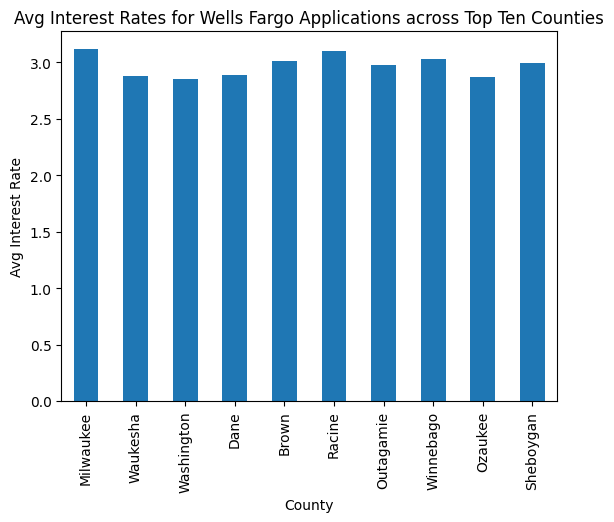

In [36]:
x.set_index("name").plot(kind="bar", legend=False)
plt.xlabel("County")
plt.ylabel("Avg Interest Rate")
plt.title("Avg Interest Rates for Wells Fargo Applications across Top Ten Counties")
plt.show()


In [37]:
#q8
# Situation 1: GROUP BY county_code
# No Exhange in the Physical Plan. Since while loading the data into Hive table we specified it should be bucketedBy "8"
# basis the county_code, so no network I/O required in this situation, as data for each county_code is likely stored on 
# the same node/bucket.
loans = loans.withColumn("interest_rate", col("interest_rate").cast("double"))
loans.groupBy("county_code").mean("interest_rate").explain("formatted")


# Situation 2: GROUP BY lei column
# Exchange present in the Physical Plan at index 4. Network I/O may be required in this situation, since all the lei cannot
# be guatanteed to be in the same bucket as mentioned above we created Hive table by bucketing county_code and not lei so
# it is possible that the data for different "lei" values is distributed across nodes. The partial results for each 
# "lei" group may need to be combined from multiple nodes to compute the final mean and hence once can expect some network 
# I/O to take place here.
loans.groupBy("lei").mean("interest_rate").explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (5)
+- HashAggregate (4)
   +- HashAggregate (3)
      +- Project (2)
         +- Scan parquet spark_catalog.default.loans (1)


(1) Scan parquet spark_catalog.default.loans
Output [2]: [county_code#695, interest_rate#714]
Batched: true
Bucketed: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,interest_rate:string>
SelectedBucketsCount: 8 out of 8

(2) Project
Output [2]: [county_code#695, cast(interest_rate#714 as double) AS interest_rate#1911]
Input [2]: [county_code#695, interest_rate#714]

(3) HashAggregate
Input [2]: [county_code#695, interest_rate#1911]
Keys [1]: [county_code#695]
Functions [1]: [partial_avg(interest_rate#1911)]
Aggregate Attributes [2]: [sum#2114, count#2115L]
Results [3]: [county_code#695, sum#2116, count#2117L]

(4) HashAggregate
Input [3]: [county_code#695, sum#2116, count#2117L]
Keys [1]: [county_code#695]
Functions [1]: [avg(interest_rate#1911)]
Aggregate

In [38]:
action_taken=spark.table("action_taken")
action_taken.limit(10).toPandas()

,id,action_taken
0,1,Loan originated
1,2,Application approved but not accepted
2,3,Application denied by financial institution
3,4,Application withdrawn by applicant
4,5,File closed for incompleteness
5,6,Loan purchased by the institution
6,7,Preapproval request denied by financial instit...
7,8,Preapproval request approved but not accepted


In [39]:
# First, perform the join
joined_df = loans.join(action_taken, on=loans["action_taken"] == action_taken["id"], how="inner")

In [40]:
df = loans.join(action_taken, on=loans["action_taken"] == action_taken["id"], how="inner").select(
    col("loan_amount").cast("double"),
    col("income").cast("double"),
    col("interest_rate"),
    when(action_taken["action_taken"].like("%Loan originated%"), 1).otherwise(0).alias("approval")
)

df = df.fillna(0.0, subset=["loan_amount", "income", "interest_rate","approval"])

df.limit(2).toPandas()

,loan_amount,income,interest_rate,approval
0,255000.0,210.0,0.000,1
1,435000.0,0.0,3.125,0


In [41]:
# deterministic split
train, test = df.randomSplit([0.8, 0.2], seed=41) 

In [42]:
train = train.cache()

In [43]:
train.count(), test.count()

(357528, 89839)

In [44]:
#q9
approved_loans = train.filter(train["approval"] == 1).count()
approved_loans

242868

In [45]:
va = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features")
va

VectorAssembler_36378b920df7

In [46]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="approval", maxDepth=5)
model = dt.fit(va.transform(train))

In [47]:
predictions = model.transform(va.transform(test))

In [48]:
accuracy = MulticlassClassificationEvaluator(labelCol="approval", predictionCol="prediction", metricName="accuracy")

In [49]:
#q10
x = accuracy.evaluate(predictions)
x

0.8932646178163158